In [14]:
import os
import healpy as h
import collections
from modules.calc_EB_rec_noise.fast_calc_eb_rec_noise import calc_eb_rec_noise
from modules.calc_TB_rec_noise.fast_calc_tb_rec_noise import calc_tb_rec_noise
from modules import eb_rec
from modules import tb_rec

from astropy.io import fits
figpath="./smica_new/"

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
ensure_dir(figpath)

# jpegpath=figpath + "/jpeg/" ; ensure_dir(jpegpath)
datapath=figpath + "/data_smica/" ; ensure_dir(datapath)

%pylab notebook

def return_Nl(fwhm,noise_rms,lmax):
    ell=np.arange(lmax+1)
    noise_rms=noise_rms*(1./60.)*(np.pi/180.)
    thetab=((fwhm/60.)*np.pi/180.)/np.sqrt(8.*np.log(2))
    Bl=exp(thetab**2 *(ell*(ell+1))/2)
    return ell,noise_rms**2. * Bl**2.

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/envs/hp/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Theory power spectra

In [44]:
nside=1024
lmax=1536
lmin=2
lpad=200
Lmax=512

clthry=np.loadtxt("../T2P_leakage/planck_2015_cmb/planck_2015_cmb_totCls.dat")
clthry=np.loadtxt("../T2P_leakage/planck_2015_cmb/planck_2015_cmb_lensedtotCls.dat")
clthry=np.loadtxt("./planck_cmb_cl/cmb_cl.txt")

maxell=3500
ell=clthry[:maxell+1,0] ; fl=ell*(ell+1)/(2.*pi)
cltt=clthry[:maxell+1,1]/fl ; cltt=append([0.,0.],cltt)
clte=clthry[:maxell+1,2]/fl ; clte=append([0.,0.],clte)
clee=clthry[:maxell+1,3]/fl ; clee=append([0.,0.],clee)
clbb=clthry[:maxell+1,4]/fl ; clbb=append([0.,0.],clbb)
ell=append([0.,1,],ell) ; fl=ell*(ell+1)/(2.*pi)
clthr=[cltt,clee,clbb,clte]

# Read data

In [45]:
fname="/Users/adityarotti/Documents/Work/Data/Planck/maps/COM_CMB_IQU-smica_2048_R3.00_full.fits"
tqu=h.read_map(fname,(0,1,2),dtype=np.float64,verbose=False)*1e6

/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


In [46]:
tmask=h.read_map(fname,8,dtype=np.float64,verbose=False)
pmask=h.read_map(fname,9,dtype=np.float64,verbose=False)

mask=tmask*pmask
mask=h.ud_grade(mask,nside)
fsky=sum(mask)/size(mask)
print(fsky)

# maskname="/Users/adityarotti/Documents/Work/Data/Planck/masks/HFI_Mask_GalPlane-apo2_2048_R2.00.fits"
# # maskname="/Users/adityarotti/Documents/Work/Data/Planck/masks/HFI_Mask_GalPlane-apo0_2048_R2.00.fits"
# mask52=h.read_map(maskname,2,dtype=np.float64,verbose=False)
# mask52=h.ud_grade(mask52,nside)*mask
# fsky52=sum(mask52)/size(mask52)
# mask62=h.read_map(maskname,3,dtype=np.float64,verbose=False)
# mask62=h.ud_grade(mask62,nside)*mask
# fsky62=sum(mask62)/size(mask62)
# mask72=h.read_map(maskname,4,dtype=np.float64,verbose=False)
# mask72=h.ud_grade(mask72,nside)*mask
# fsky72=sum(mask72)/size(mask72)

0.9550765951474508


In [47]:
f=fits.open(fname)
blsmica=f[2].data.field(0)[:lmax+1]
invbl=np.zeros_like(blsmica)
invbl[2:]=1./blsmica[2:] ; invbl[0]=1. ; invbl[1]=1.

## Spectra plots

In [48]:
alm=h.map2alm(tqu,pol=True,lmax=lmax+lpad)
alm[0]=h.almxfl(alm[0],fl=invbl)
alm[1]=h.almxfl(alm[1],fl=invbl)
alm[2]=h.almxfl(alm[2],fl=invbl)
dec_tqu=h.alm2map(alm,pol=True,nside=nside)

/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


In [49]:
# pwc=h.pixwin(2048,lmax=lmax,pol=True)
# pwc[1]

<IPython.core.display.Javascript object>


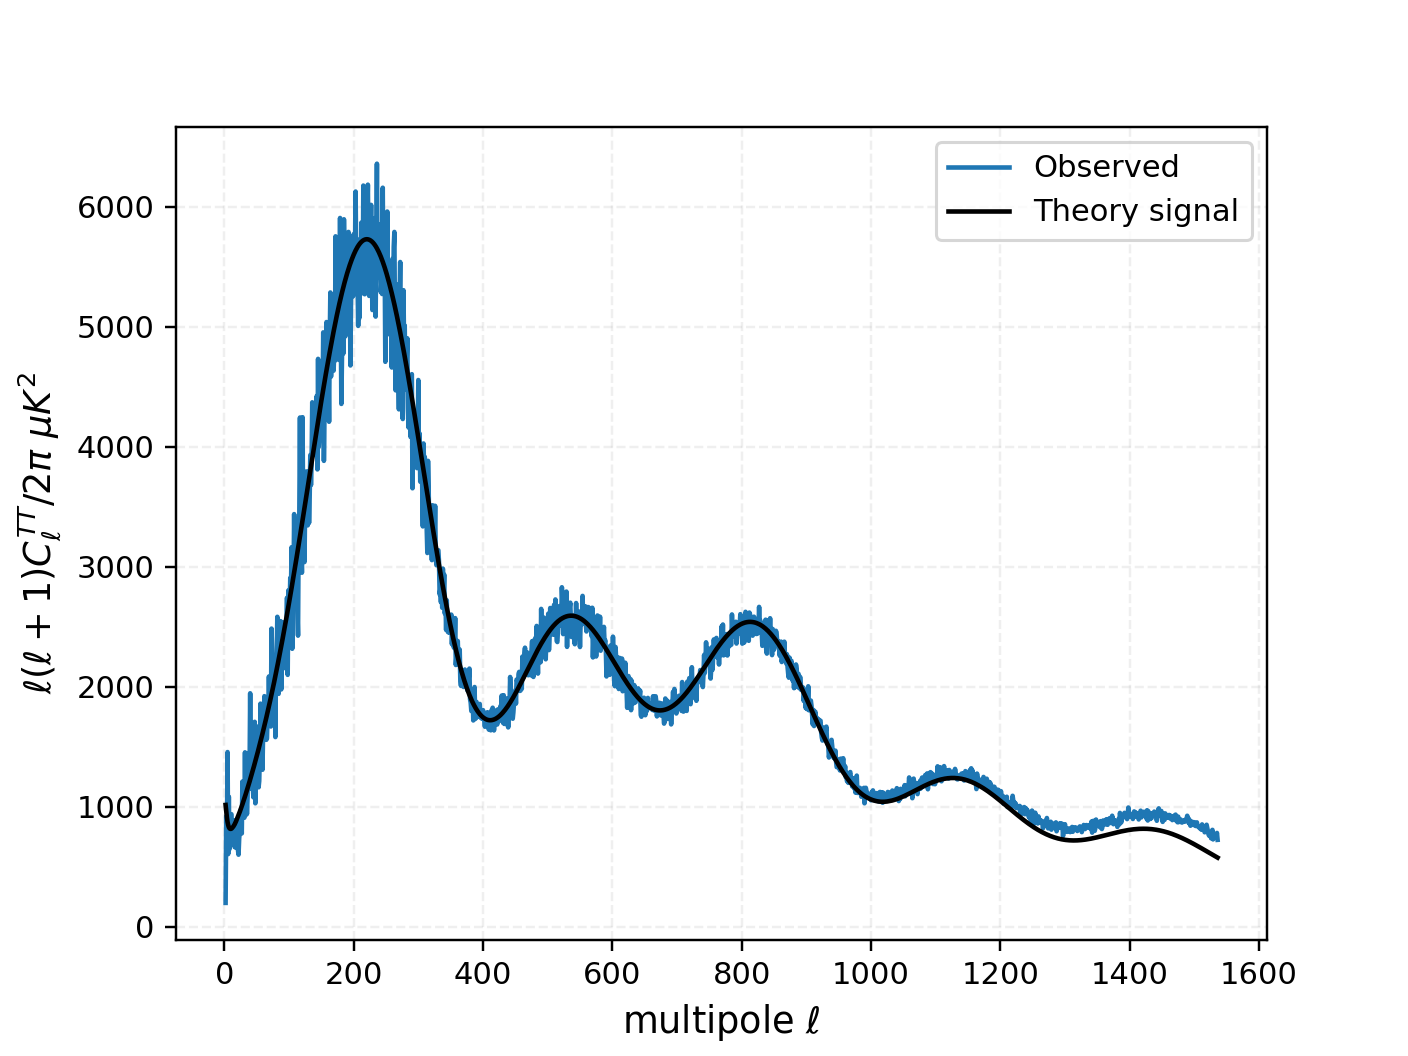

<IPython.core.display.Javascript object>


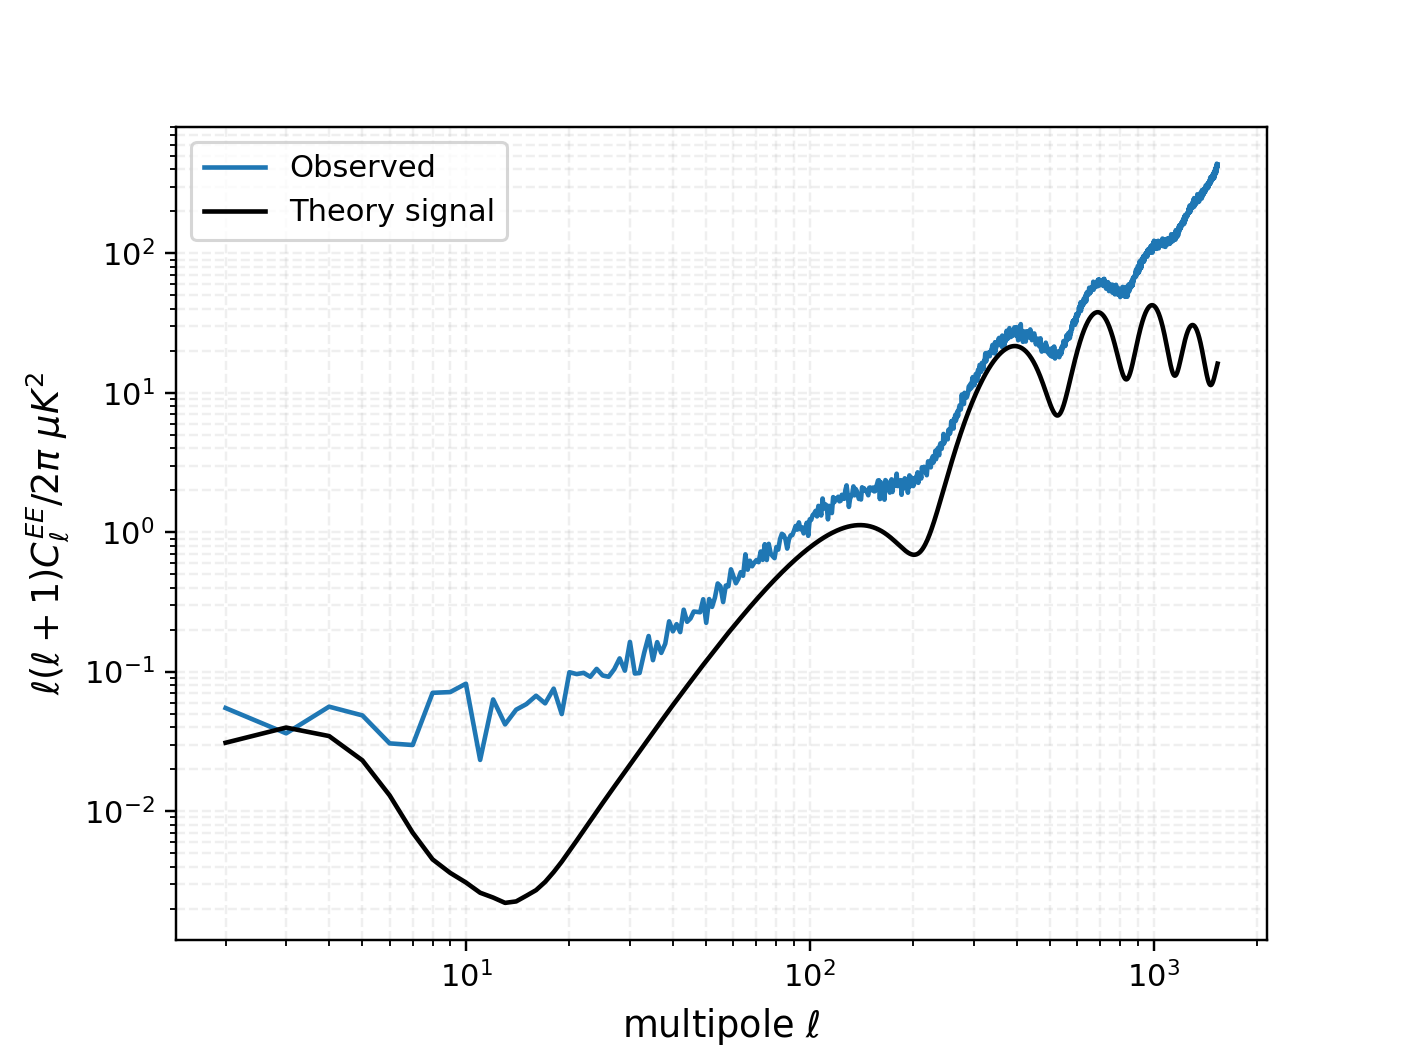

<IPython.core.display.Javascript object>


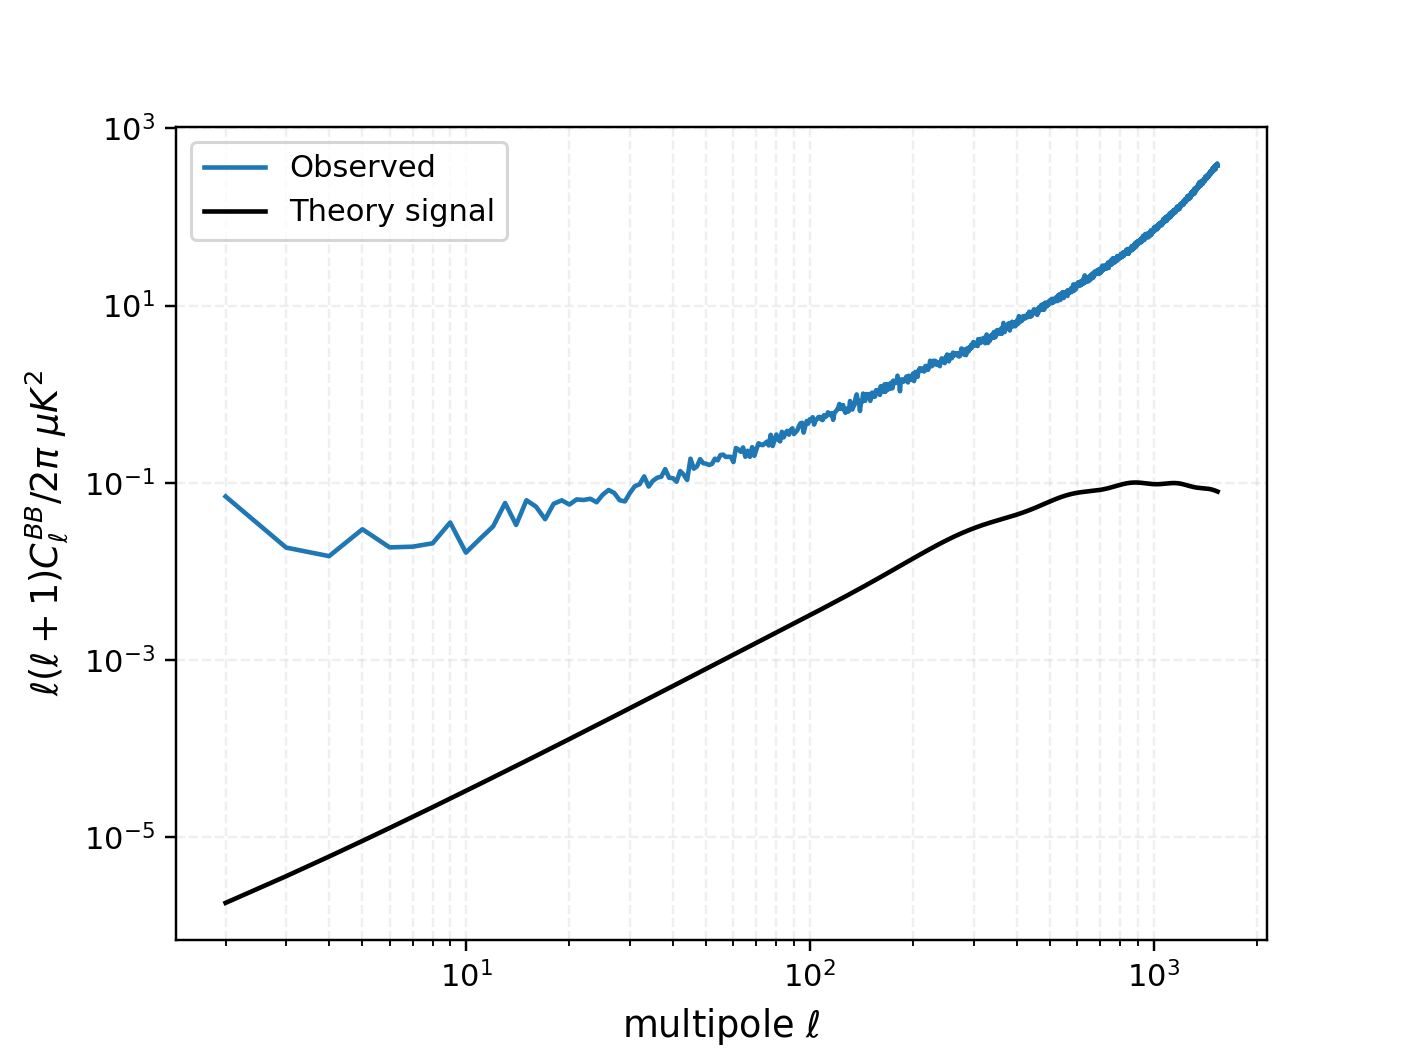

<IPython.core.display.Javascript object>


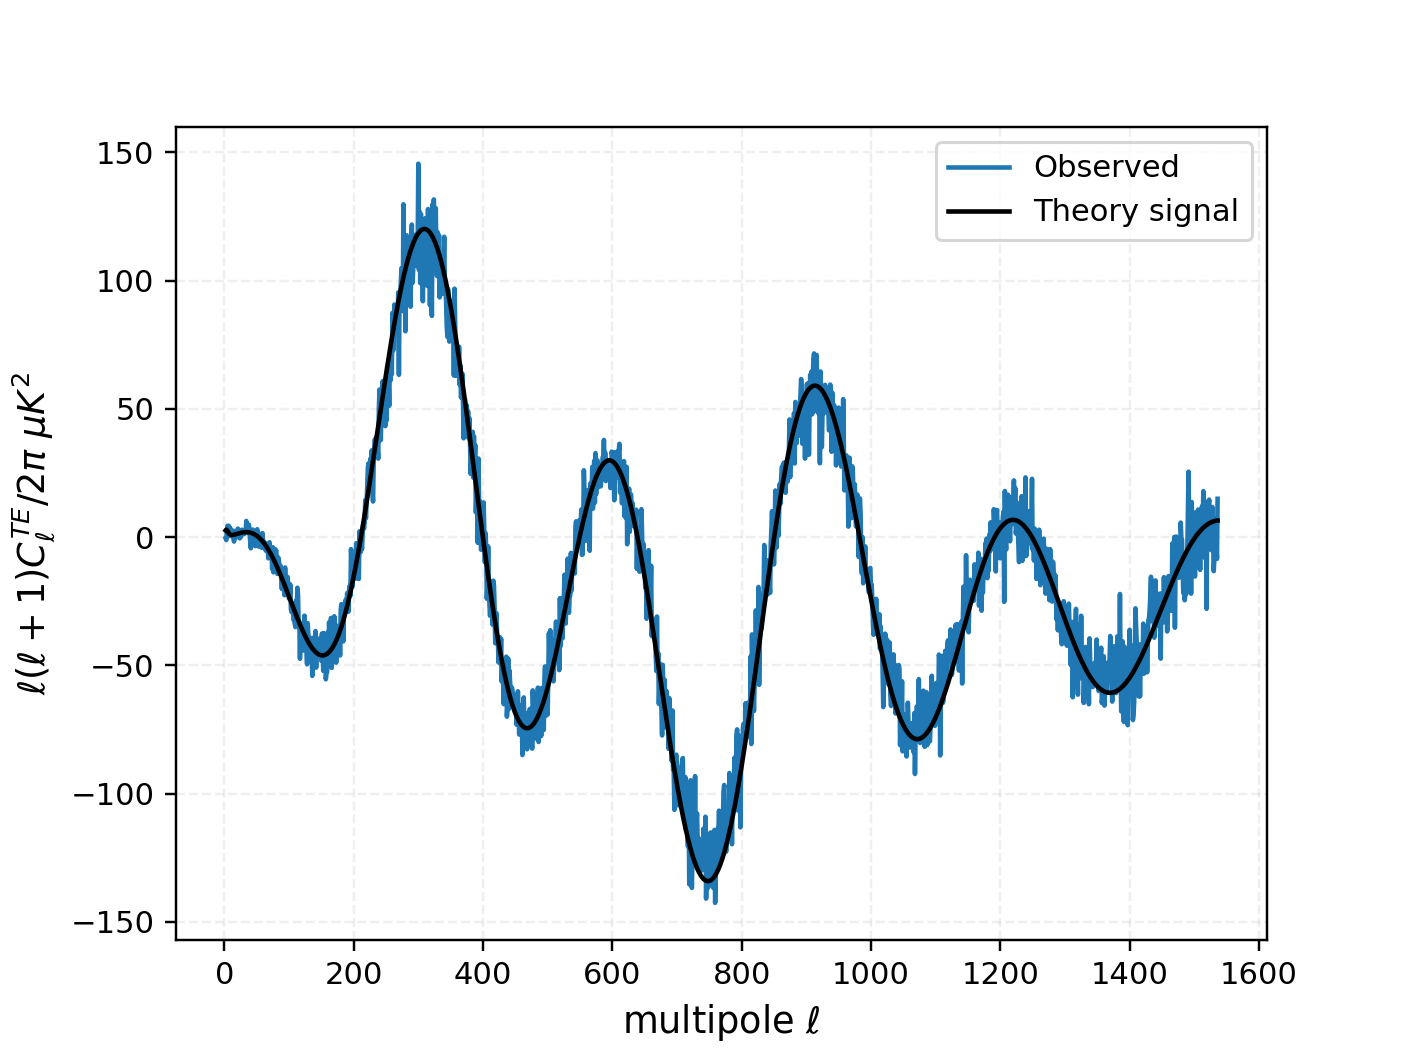

In [50]:
clobs=h.alm2cl(alm)
ell=np.arange(lmax+1)
fl=ell*(ell+1)/(2.*pi)

cmp_list=["TT","EE","BB","TE"]

for idx in range(4):
    figure()
    plot(ell[2:],fl[2:]*clobs[idx][2:lmax+1],label="Observed")
    plot(ell[2:],fl[2:]*clthr[idx][2:lmax+1],"k-",label="Theory signal")
    xlabel(r"multipole $\ell$",fontsize=12)
    ylabel(r"$\ell(\ell+1)C_{\ell}^{" + cmp_list[idx] + "}/2 \pi$ $\mu K ^2$",fontsize=12)
    if idx!=0 and idx!=3:
        loglog()
    legend(loc=0)
    grid(which="both",linestyle="dashed",alpha=0.2)
    filename=figpath + cmp_list[idx] + "_spectrum.pdf"
    savefig(filename,bbox_inches="tight")

# QE analysis

<IPython.core.display.Javascript object>


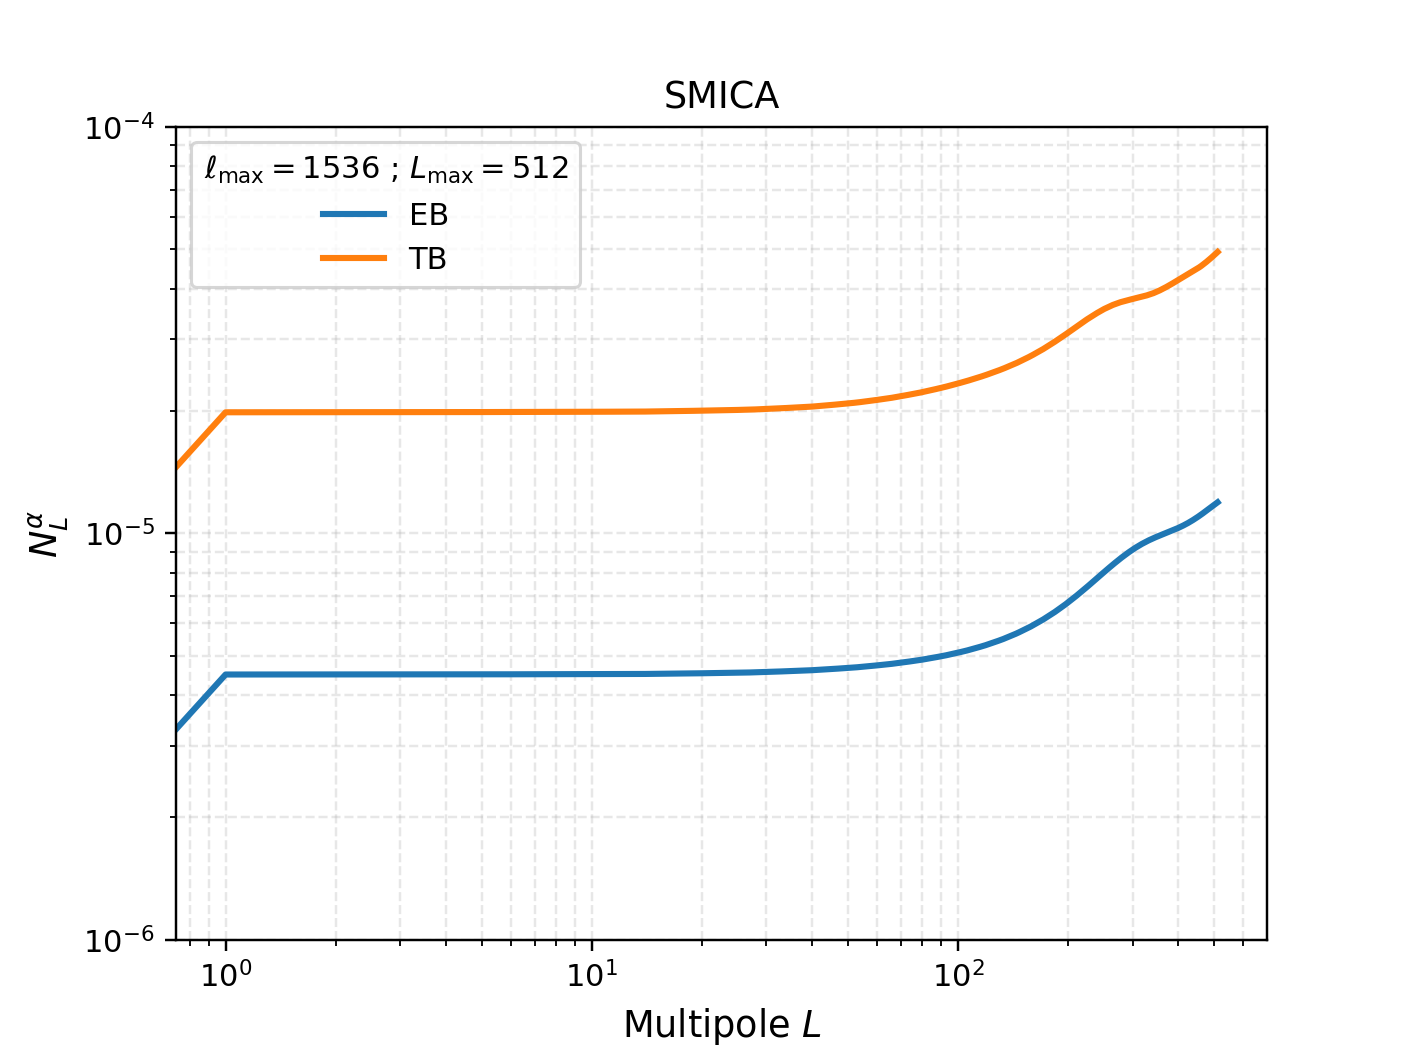

In [51]:
L=np.arange(Lmax+1)
NLeb=calc_eb_rec_noise(clthr[1],clobs[1],clobs[2],lmin,lmax,Lmax)
NLtb=calc_tb_rec_noise(clthr[3],clobs[0],clobs[2],lmin,lmax,Lmax)

figure()
plot(L,NLeb,"-",lw=2,label="EB")
plot(L,NLtb,"-",lw=2,label="TB")
loglog()
ylabel(r"$N^{\alpha}_L$",fontsize=12)
xlabel(r"Multipole $L$",fontsize=12)
grid(which="both",alpha=0.3,linestyle="dashed")
legend(loc="upper left",title=r"$\ell_{\rm max}=$" + str(lmax) + " ; " + r"$L_{\rm max}=$"+str(Lmax) )
title("SMICA")
ylim(1e-6,1e-4)
figname=figpath + "eb_vs_tb_recnoise_lmin" + str(lmin) + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".jpeg"
savefig(figname,bbox_inches="tight",dpi=250)

In [52]:
eb=eb_rec.opt_eb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask,ellmin=lmin)
eb.eb_reconstruct()

tb=tb_rec.opt_tb_qe(dec_tqu,clthr,lmax,Lmax,mask=mask,ellmin=lmin)
tb.tb_reconstruct()

<IPython.core.display.Javascript object>


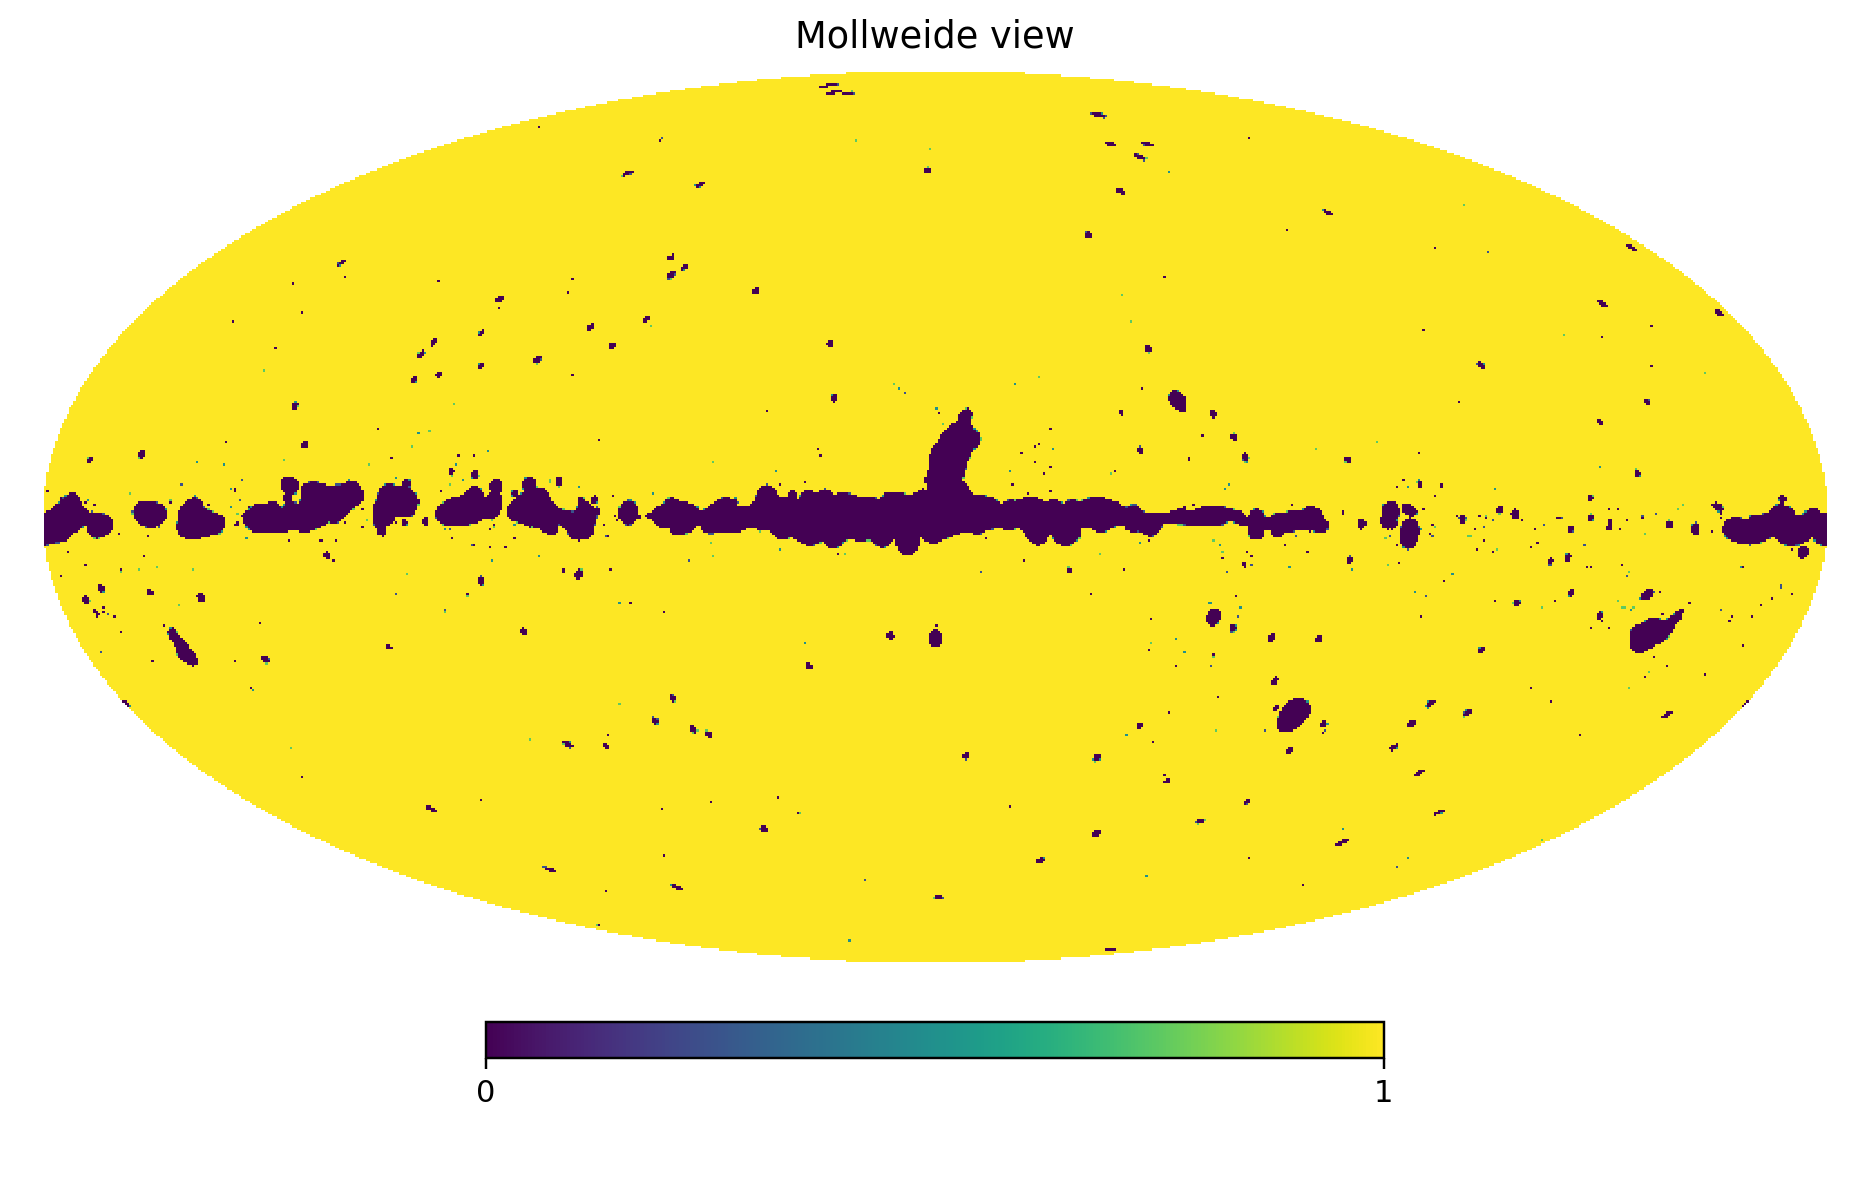

/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This

In [53]:
h.mollview(mask)

<IPython.core.display.Javascript object>


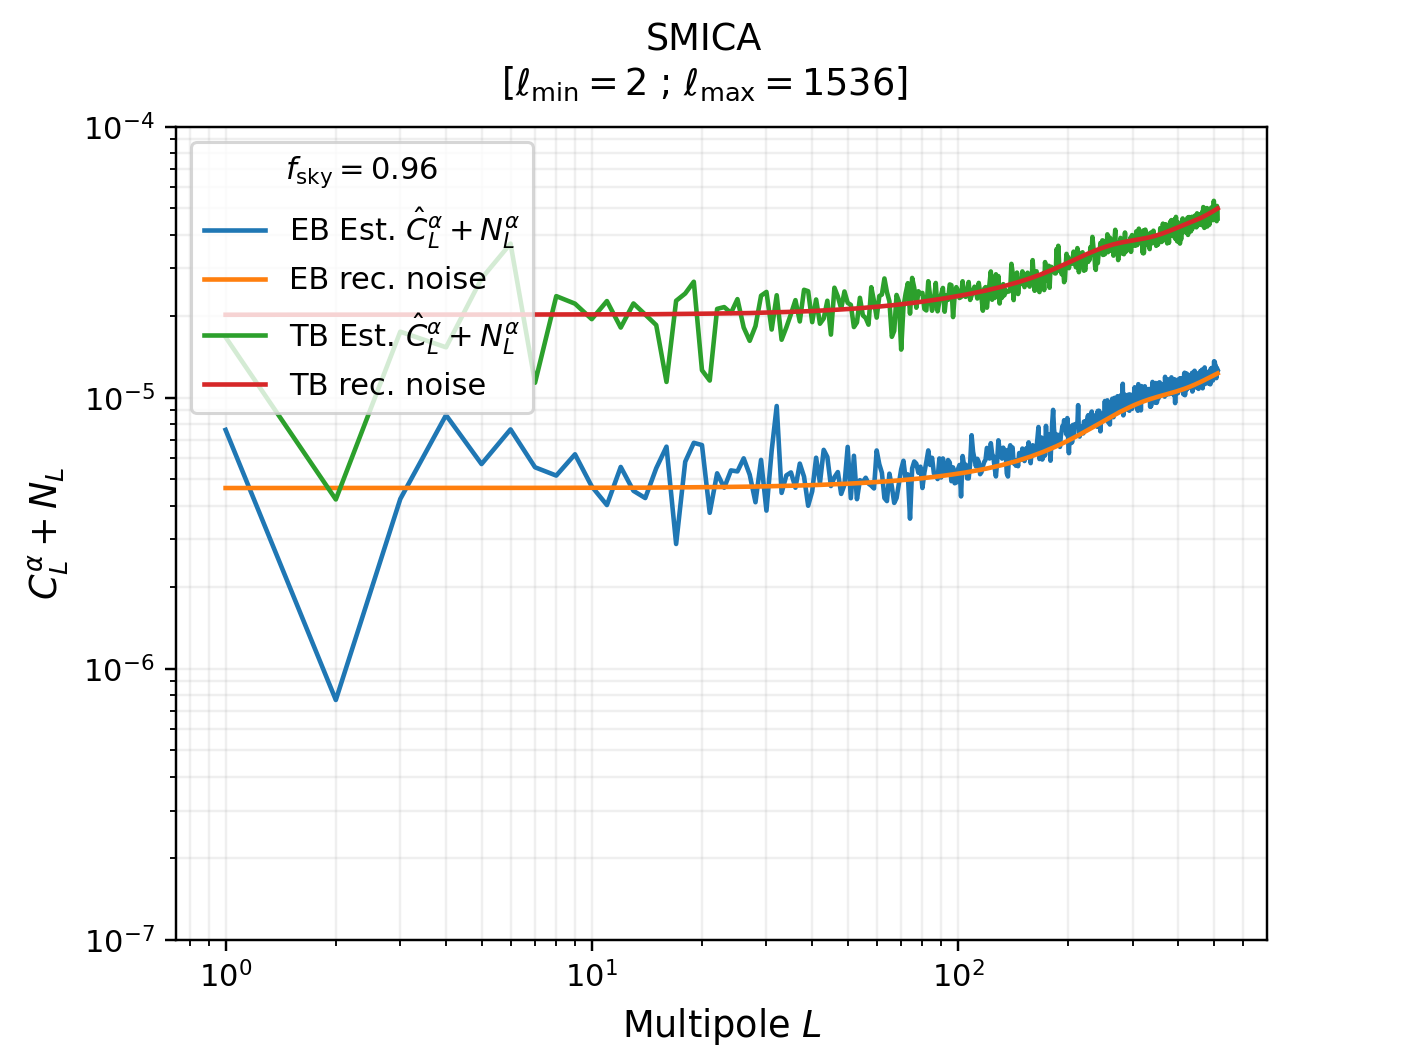

In [54]:
figure()
L=np.arange(eb.Lmax+1)
fL=np.ones(eb.Lmax+1,np.float64)
plot(L[1:],fL[1:]*eb.Cl_rec_alpha[1:],label=r"EB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
plot(L[1:],fL[1:]*eb.N_L[1:],label=r"EB rec. noise")
plot(L[1:],fL[1:]*tb.Cl_rec_alpha[1:],label=r"TB Est. $\hat{C}^{\alpha}_{L} + N^{\alpha}_{L}$")
plot(L[1:],fL[1:]*tb.N_L[1:],label=r"TB rec. noise")
loglog()
legend(loc="upper left",title=r"$f_{\rm sky}=$" + str(round(fsky,2)))
xlabel(r"Multipole $L$",fontsize=12)
ylabel(r"$C^{\alpha}_L + N_{L}$",fontsize=12)
grid(alpha=0.2,which="both")
ylim(1e-7,1e-4)
suptitle(r"SMICA" "\n" r"[$\ell_{\rm min}=$" + str(lmin) + " ; " + r"$\ell_{\rm max}=$"  + str(lmax) + "]")
figname=figpath + "smica_eb_tb_reconstructed_alpha_ps_lmin" + str(lmin) + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".jpeg"
savefig(figname,bbox_inches="tight",dpi=250)

<IPython.core.display.Javascript object>


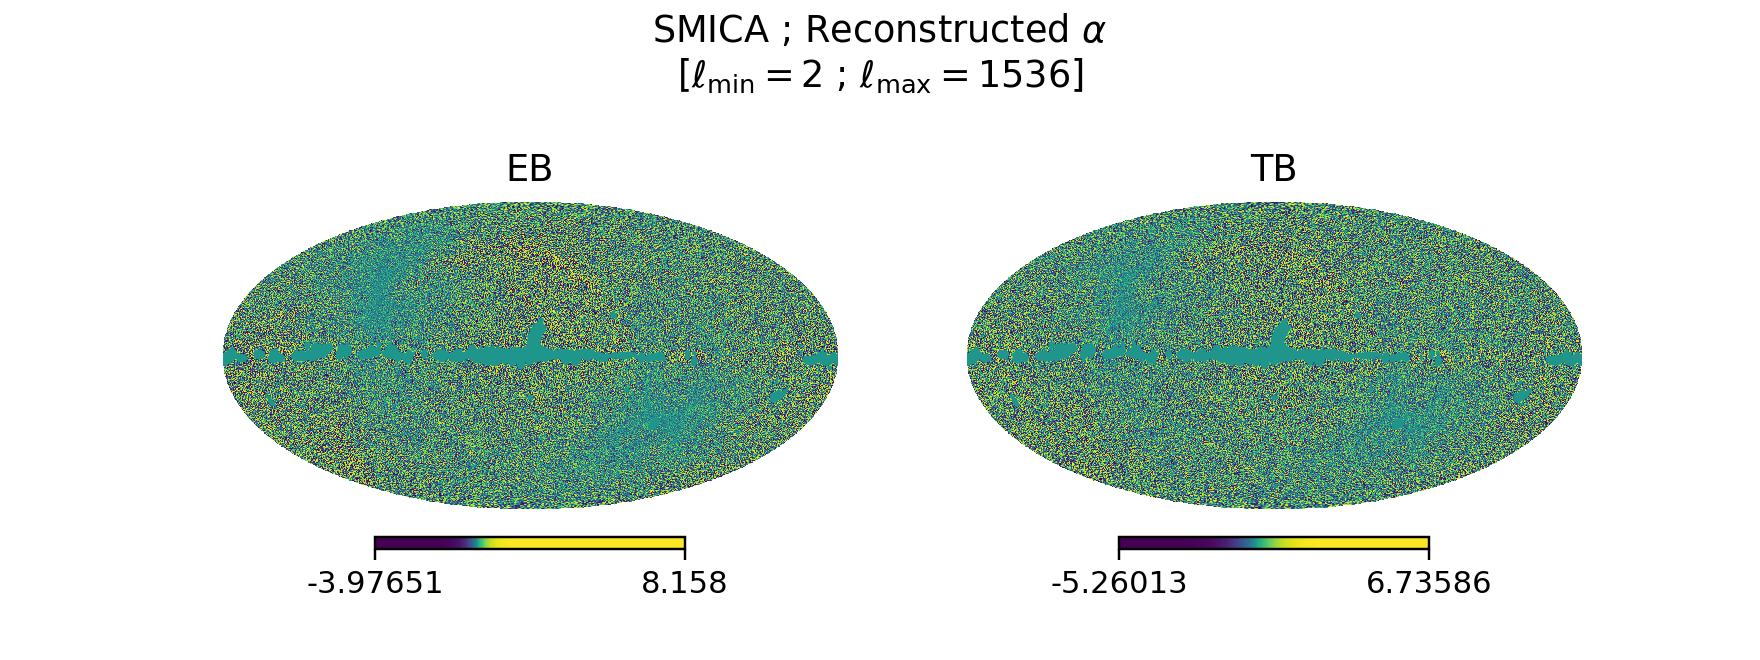

/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=[8,3.])
axes(ax1)
h.mollview(eb.rec_alpha*mask,hold=True,title="EB",norm="hist")
axes(ax2)
h.mollview(tb.rec_alpha*mask,hold=True,title="TB",norm="hist")
suptitle(r"SMICA ; Reconstructed $\alpha$" "\n" r"[$\ell_{\rm min}=$" + str(lmin) + " ; " + r"$\ell_{\rm max}=$"  + str(lmax) + "]")
figname=figpath + "smica_eb_tb_reconstructed_alpha_lmin" + str(lmin) + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) + ".jpeg"
savefig(figname,bbox_inches="tight",dpi=300)

In [56]:
file_suffix="_SMICA" + "_lmax" + str(lmax) + "_Lmax" + str(Lmax) 
filename=datapath + "NL" + file_suffix + ".txt"
print(filename)
np.savetxt(filename , eb.N_L)
filename=datapath + "CL" + file_suffix + ".txt"
np.savetxt(filename , eb.Cl_rec_alpha)
filename=datapath + "rec_alpha" + file_suffix + ".fits"
h.write_map(filename,eb.rec_alpha,overwrite=True)

./smica_new//data_smica/NL_SMICA_lmax1536_Lmax512.txt


/opt/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/fitsfunc.py:200: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning,


In [61]:
cl143=np.loadtxt("./planck143_rerun/data_143/fsky78_CL_143GHz_lmax1024_Lmax512.txt")
nl143=np.loadtxt("./planck143_rerun/data_143/fsky78_NL_143GHz_lmax1024_Lmax512.txt")
cl1431=np.loadtxt("./planck143_rerun/data_143/fsky78_CL_143GHz_lmax1536_Lmax512.txt")
nl1431=np.loadtxt("./planck143_rerun/data_143/fsky78_NL_143GHz_lmax1536_Lmax512.txt")
nlsmica=np.loadtxt("./smica_new/data_smica/NL_SMICA_lmax1024_Lmax512.txt")
clsmica=np.loadtxt("./smica_new/data_smica/CL_SMICA_lmax1024_Lmax512.txt")
nlsmica1=np.loadtxt("./smica_new/data_smica/NL_SMICA_lmax1536_Lmax512.txt")
clsmica1=np.loadtxt("./smica_new/data_smica/CL_SMICA_lmax1536_Lmax512.txt")

<IPython.core.display.Javascript object>


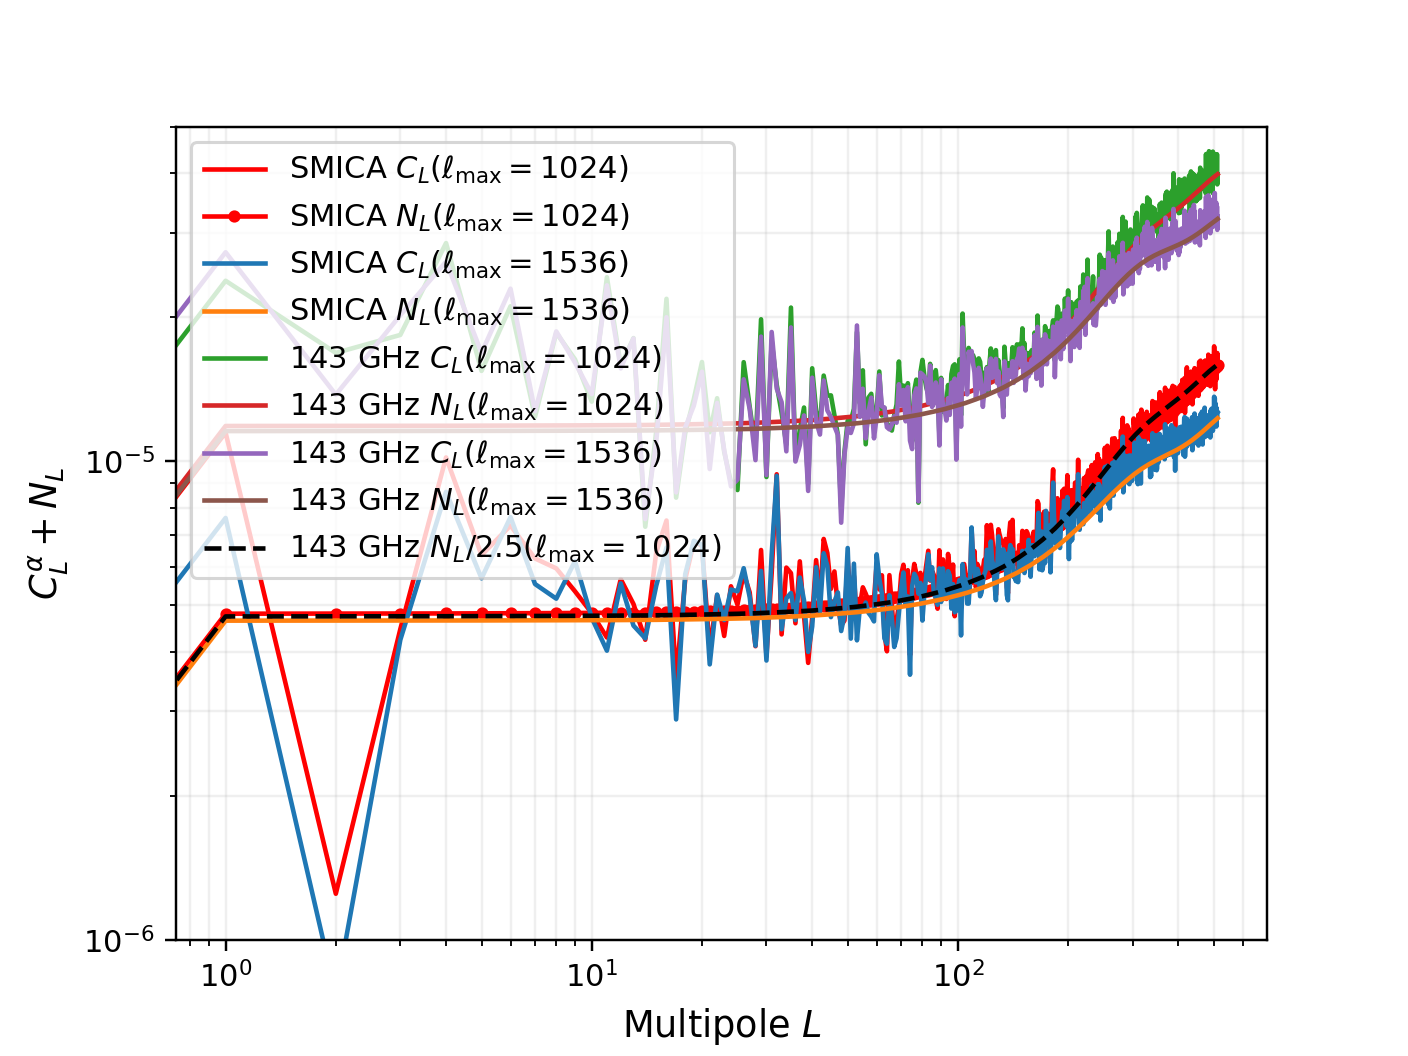

In [63]:
figure()
plot(clsmica,"r-",label=r"SMICA $C_L (\ell_{\rm max}=1024)$")
plot(nlsmica,"r.-",label=r"SMICA $N_L (\ell_{\rm max}=1024)$")
plot(clsmica1,label=r"SMICA $C_L (\ell_{\rm max}=1536)$")
plot(nlsmica1,label=r"SMICA $N_L (\ell_{\rm max}=1536)$")
plot(cl143,label=r"143 GHz $C_L (\ell_{\rm max}=1024)$")
plot(nl143,label=r"143 GHz $N_L (\ell_{\rm max}=1024)$")
plot(cl1431,label=r"143 GHz $C_L (\ell_{\rm max}=1536)$")
plot(nl1431,label=r"143 GHz $N_L (\ell_{\rm max}=1536)$")
plot(nl143/2.5,"k--",label=r"143 GHz $N_L/2.5 (\ell_{\rm max}=1024)$")
loglog()
ylim(1e-6,5e-5)
legend(loc="upper left")#,title=r"$f_{\rm sky}=$" + str(round(fsky,2)))
xlabel(r"Multipole $L$",fontsize=12)
ylabel(r"$C^{\alpha}_L + N_{L}$",fontsize=12)
grid(alpha=0.2,which="both")
figname="compare_smica_vs_143ghz.pdf"
savefig(figname,bbox_inches='tight')

# Likelihood

In [116]:
clthry=np.zeros(Lmax+1,np.float64)
clthry[1:]=1./(L[1:]*(L[1:]+1))

def bire_lkl(A,Clobs,Nl,clthry,fsky,Lmax):
    L=np.arange(Lmax+1)
    var=(2./((2.*L+1)*fsky))*Nl[:Lmax+1]**2.
    chi2=np.sum((Clobs[1:Lmax+1]-A*clthry[1:Lmax+1])**2/var[1:Lmax+1])
    return chi2

Avals=np.logspace(-5,2,1000)

In [117]:
chi2=np.zeros_like(Avals)
for i,A in enumerate(Avals):
    chi2[i]=bire_lkl(A,eb.Cl_rec_alpha,eb.N_L,clthry,eb.fsky,512)

<IPython.core.display.Javascript object>


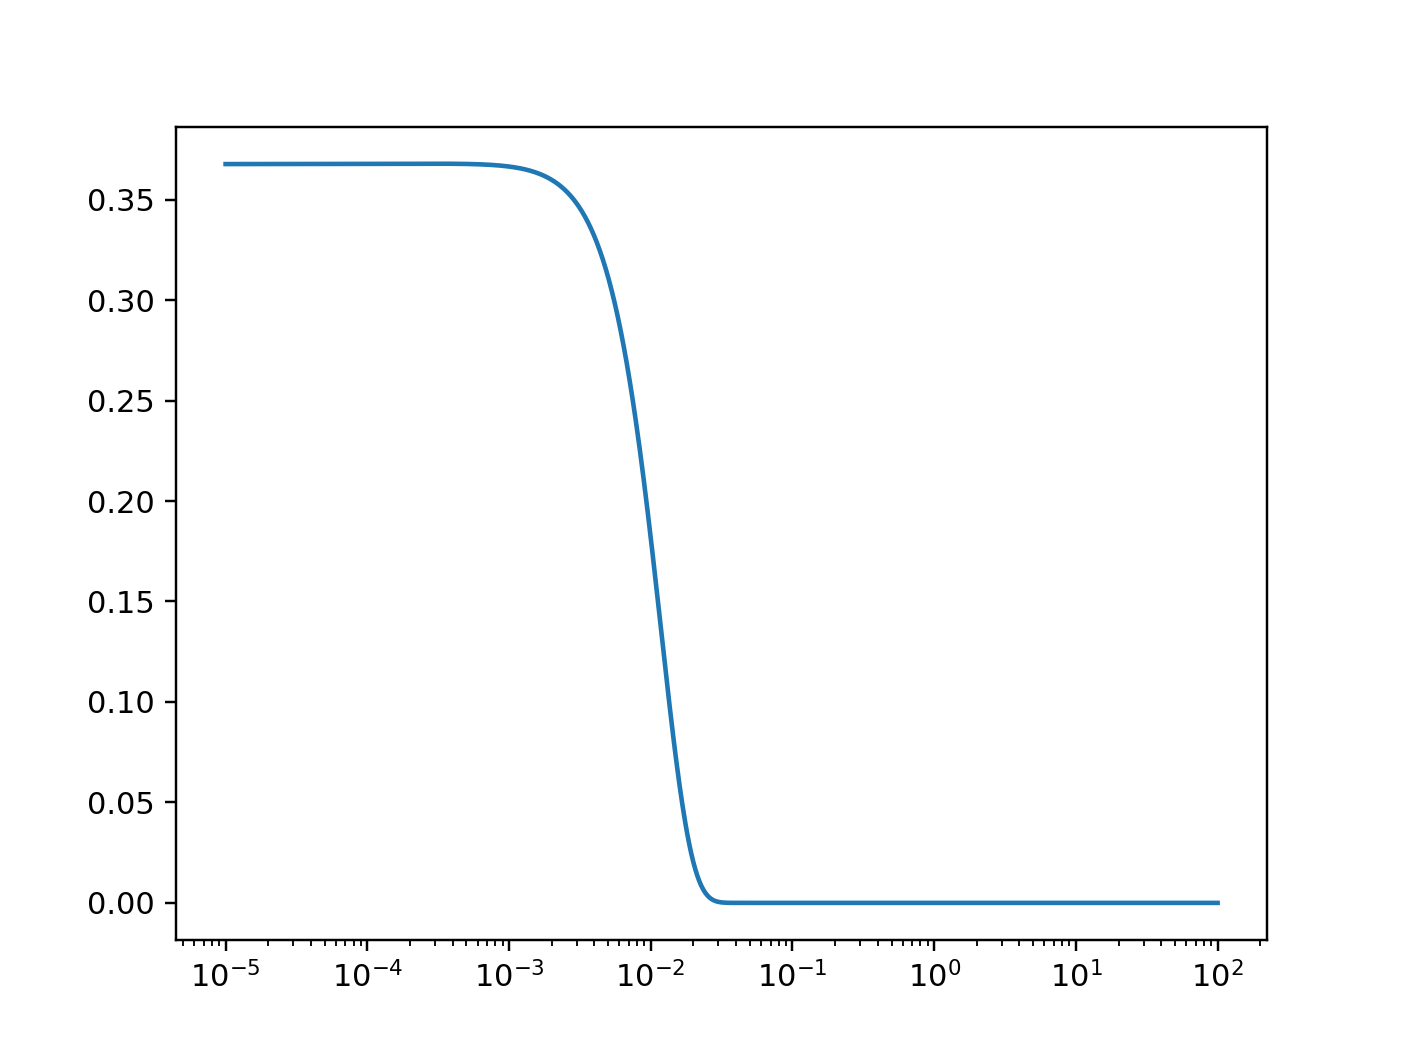

[]

In [118]:
chi2=chi2/min(chi2)
figure()
plot(Avals,exp(-chi2))
semilogx()